In [4]:
from google.colab import drive
import pathlib
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [84]:
import os
import shutil
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
import xml.etree.ElementTree as ET
import sklearn.svm
import sklearn.cluster
import sklearn.linear_model
import sklearn.model_selection
import sklearn.tree
import lightgbm
import sklearn.metrics
import xgboost
from sklearn.decomposition import PCA
import matplotlib.pyplot
import numpy as np
import sklearn.ensemble

In [52]:
seed = 17

In [42]:
def calculatefscore(expected,actual):
  TP=0
  FP=0
  FN=0
  TN=0
  for i in range(len(expected)):
    if actual[i]>=1 and expected[i]==1:
      TP=TP+1
    elif actual[i]==1 and expected[i]==0:
      FP=FP+1
    elif actual[i]==0 and expected[i]==1:
      FN=FN+1
    

  fscore=2*TP/(2*TP+FP+FN)
  print("TP: "+ str(TP))
  print("FP: "+ str(FP))
  print("FN: "+ str(FN))

In [15]:
malPermissionsMap = pd.DataFrame(columns=['AppName', 'Permissions','isBenign'])
malPermissionsMapFeat1 = pd.DataFrame(columns=['AppName','Permissions','Receiver','isBenign'])

mal_dir = "/content/drive/MyDrive/extractedmanifestmalign"
for fileName in os.listdir(mal_dir):
  if fileName == '.DS_Store':
    continue
  androidManifest = ET.parse(mal_dir+'/'+fileName)
  appName = fileName[:len(fileName)-20]
  permissionsList = []
  receiverList= []
  for permission in androidManifest.findall('uses-permission'):
    permissionsList.append(permission.attrib['{http://schemas.android.com/apk/res/android}name'])
  for receiver in androidManifest.findall('application/receiver'):
    receiverList.append(receiver.attrib['{http://schemas.android.com/apk/res/android}name'])
  malPermissionsMap.loc[len(malPermissionsMap.index)] = [appName, permissionsList,0]
  malPermissionsMapFeat1.loc[len(malPermissionsMapFeat1.index)] = [appName,permissionsList,receiverList,0]

benPermissionsMap = pd.DataFrame(columns=['AppName', 'Permissions','isBenign'])
benPermissionsMapFeat1 = pd.DataFrame(columns=['AppName','Permissions','Receiver','isBenign'])

ben_dir = "/content/drive/My Drive/extractedmanifestbenign"
for fileName in os.listdir(ben_dir):
  if fileName == '.DS_Store':
    continue
  androidManifest = ET.parse(ben_dir+'/'+fileName)
  appName = fileName[:len(fileName)-20]
  permissionsList = []
  receiverList= []
  for permission in androidManifest.findall('uses-permission'):
    permissionsList.append(permission.attrib['{http://schemas.android.com/apk/res/android}name'])
  for receiver in androidManifest.findall('application/receiver'):
    receiverList.append(receiver.attrib['{http://schemas.android.com/apk/res/android}name'])
  benPermissionsMap.loc[len(benPermissionsMap.index)] = [appName, permissionsList,1]
  benPermissionsMapFeat1.loc[len(benPermissionsMapFeat1.index)] = [appName,permissionsList,receiverList,1]
permissionsMap=pd.concat([benPermissionsMap,malPermissionsMap],ignore_index=True)
permissionsMapFeat1=pd.concat([benPermissionsMapFeat1,malPermissionsMapFeat1],ignore_index=True)

multiLableBinarizer = MultiLabelBinarizer(sparse_output=True)
permissionsMap = permissionsMap.join(pd.DataFrame.sparse.from_spmatrix(multiLableBinarizer.fit_transform(permissionsMap.pop('Permissions')),index=permissionsMap.index,columns=multiLableBinarizer.classes_))
permissionsMap = permissionsMap.drop('AppName', axis=1)
isBen=permissionsMap.isBenign
permissionsMap = permissionsMap.drop('isBenign', axis=1)
permissionsMap=permissionsMap.to_numpy()
isBen=isBen.to_numpy()

multiLableBinarizer = MultiLabelBinarizer(sparse_output=True)
permissionsMapFeat1 = permissionsMapFeat1.join(pd.DataFrame.sparse.from_spmatrix(multiLableBinarizer.fit_transform(permissionsMapFeat1.pop('Permissions')),index=permissionsMapFeat1.index,columns=multiLableBinarizer.classes_))
permissionsMapFeat1 = permissionsMapFeat1.join(pd.DataFrame.sparse.from_spmatrix(multiLableBinarizer.fit_transform(permissionsMapFeat1.pop('Receiver')),index=permissionsMapFeat1.index,columns=multiLableBinarizer.classes_))
print(permissionsMapFeat1.head())
permissionsMapFeat1 = permissionsMapFeat1.drop('AppName', axis=1)
isBenFeat1=permissionsMapFeat1.isBenign
permissionsMapFeat1 = permissionsMapFeat1.drop('isBenign', axis=1)
permissionsMapFeat1=permissionsMapFeat1.to_numpy()
isBenFeat1=isBenFeat1.to_numpy()

                          AppName isBenign  \
0             com.nytimes.android        1   
1           com.mw.rouletteroyale        1   
2   com.musixmatch.android.lyrify        1   
3            com.oldwang1.darts-2        1   
4  com.nb.fingerprint.lock.free-7        1   

   android.hardware.sensor.accelerometer  android.permission.ACCESS_COARSE  \
0                                      0                                 0   
1                                      0                                 0   
2                                      0                                 0   
3                                      0                                 0   
4                                      0                                 0   

   android.permission.ACCESS_COARSE_LOCATION  \
0                                          1   
1                                          1   
2                                          0   
3                                          0   
4             

Text(0, 0.5, 'Fraction of total variance explained')

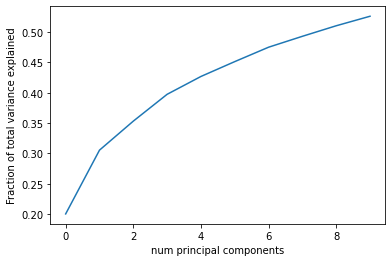

In [53]:
trainSet,testSet,trainRes,testRes = sklearn.model_selection.train_test_split(permissionsMapFeat1,isBen, test_size=0.2, random_state=17)
n_components = 10

pca = PCA(n_components=n_components).fit(trainSet)
matplotlib.pyplot.plot(np.cumsum(pca.explained_variance_ratio_))
np.cumsum(pca.explained_variance_ratio_)
matplotlib.pyplot.xlabel('num principal components')
matplotlib.pyplot.ylabel('Fraction of total variance explained')


In [54]:
n_components = 3

In [55]:
pca = PCA(n_components=n_components).fit(trainSet)

In [56]:
X_train_pca = pca.transform(trainSet)
X_test_pca = pca.transform(testSet)

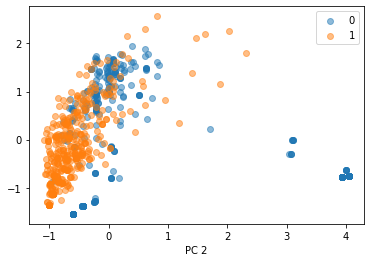

In [57]:
fig, ax = matplotlib.pyplot.subplots(1)

for i in range(2):
    ax.scatter(X_train_pca[trainRes==i][:,0], X_train_pca[trainRes==i][:,1], label=[0, 1][i], alpha=0.5)
    
ax.set_xlabel('PC 1')
ax.set_xlabel('PC 2')
ax.legend()

In [58]:
X_train_pca

array([[ 0.37899755,  1.14115593, -0.45531669],
       [-0.40127535, -0.07632574, -0.66009107],
       [-0.94221931, -1.13074674,  0.10955315],
       ...,
       [-0.94249631, -1.13366689,  0.10919017],
       [-0.94249631, -1.13366689,  0.10919017],
       [-0.22398721,  1.68823543, -0.12725985]])

In [59]:
len(X_train_pca)

777

In [60]:
trainRes = trainRes.astype('int')

In [61]:
from sklearn.svm import SVC
svc = SVC(C=10000, kernel='rbf')
svc.fit(X_train_pca, trainRes)

SVC(C=10000)

In [62]:
y_pred = svc.predict(X_test_pca)

In [63]:
testRes = testRes.astype('int')

In [64]:
from sklearn.metrics import classification_report

print(classification_report(testRes, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87       105
           1       0.84      0.87      0.85        90

    accuracy                           0.86       195
   macro avg       0.86      0.86      0.86       195
weighted avg       0.86      0.86      0.86       195



In [65]:
print("SVM")
fscore=calculatefscore(testRes,y_pred)

SVM
TP: 78
FP: 15
FN: 12


In [66]:
lgbmClassifier=lightgbm.LGBMClassifier()
lgbmClassifier.fit(X_train_pca, trainRes)
predLGBM = lgbmClassifier.predict(X_test_pca)

In [67]:
print(classification_report(testRes, predLGBM))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90       105
           1       0.92      0.84      0.88        90

    accuracy                           0.89       195
   macro avg       0.90      0.89      0.89       195
weighted avg       0.89      0.89      0.89       195



In [68]:
print("LGBM")
fscore=calculatefscore(testRes,predLGBM)

LGBM
TP: 76
FP: 7
FN: 14


In [69]:
decisionTreeClassifier=sklearn.tree.DecisionTreeClassifier()
decisionTreeClassifier.fit(X_train_pca, trainRes)
predDTC = decisionTreeClassifier.predict(X_test_pca)
print(classification_report(testRes, predDTC))

              precision    recall  f1-score   support

           0       0.85      0.94      0.90       105
           1       0.92      0.81      0.86        90

    accuracy                           0.88       195
   macro avg       0.89      0.88      0.88       195
weighted avg       0.89      0.88      0.88       195



In [70]:
print("Decision Tree")
fscore=calculatefscore(testRes,predDTC)

Decision Tree
TP: 73
FP: 6
FN: 17


In [82]:
xgBoostClassfier = xgboost.XGBClassifier()
xgBoostClassfier.fit(X_train_pca, trainRes)
predictionsXGBoost = xgBoostClassfier.predict(X_test_pca)
print(classification_report(testRes, predictionsXGBoost))

              precision    recall  f1-score   support

           0       0.86      0.91      0.88       105
           1       0.89      0.82      0.86        90

    accuracy                           0.87       195
   macro avg       0.87      0.87      0.87       195
weighted avg       0.87      0.87      0.87       195



In [87]:
print("XGBoost Classifier")
fscore=calculatefscore(testRes,predictionsXGBoost)

XGBoost Classifier
TP: 74
FP: 9
FN: 16


In [85]:
randomForestClassifier = sklearn.ensemble.RandomForestClassifier()
randomForestClassifier.fit(X_train_pca, trainRes)
predictionsRandomForest = randomForestClassifier.predict(X_test_pca)
print(classification_report(testRes, predictionsRandomForest))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89       105
           1       0.89      0.86      0.87        90

    accuracy                           0.88       195
   macro avg       0.88      0.88      0.88       195
weighted avg       0.88      0.88      0.88       195



In [88]:
print("Random Forest")
fscore=calculatefscore(testRes,predictionsRandomForest)

Random Forest
TP: 77
FP: 10
FN: 13


In [89]:
from sklearn.decomposition import KernelPCA

n_components = 10

kpca = KernelPCA(n_components=n_components, kernel='rbf', fit_inverse_transform=True).fit(trainSet)

In [91]:
X_train_kpca = kpca.transform(trainSet)
X_test_kpca = kpca.transform(testSet)

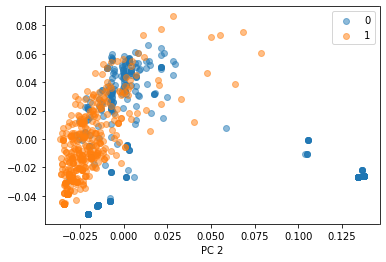

In [93]:
fig, ax = matplotlib.pyplot.subplots(1)

for i in range(2):
    ax.scatter(X_train_kpca[trainRes==i][:,0], X_train_kpca[trainRes==i][:,1], label=[0, 1][i], alpha=0.5)
    
ax.set_xlabel('PC 1')
ax.set_xlabel('PC 2')
ax.legend()

In [132]:
svc = SVC(C=10000, kernel='rbf')
svc.fit(X_train_kpca, trainRes)
y_pred_svm = svc.predict(X_test_kpca)
print(classification_report(testRes, y_pred_svm))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       105
           1       0.94      0.94      0.94        90

    accuracy                           0.95       195
   macro avg       0.95      0.95      0.95       195
weighted avg       0.95      0.95      0.95       195



In [133]:
print("SVM")
fscore=calculatefscore(testRes,y_pred_svm)

SVM
TP: 85
FP: 5
FN: 5


In [134]:
lgbmClassifier=lightgbm.LGBMClassifier()
lgbmClassifier.fit(X_train_kpca, trainRes)
predLGBMKpca = lgbmClassifier.predict(X_test_kpca)

In [135]:
print(classification_report(testRes, predLGBMKpca))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       105
           1       0.97      0.96      0.96        90

    accuracy                           0.96       195
   macro avg       0.96      0.96      0.96       195
weighted avg       0.96      0.96      0.96       195



In [136]:
print('LGBM')
fscore=calculatefscore(testRes,predLGBMKpca)

LGBM
TP: 86
FP: 3
FN: 4


In [106]:
decisionTreeClassifier=sklearn.tree.DecisionTreeClassifier()
decisionTreeClassifier.fit(X_train_kpca, trainRes)
predDTCKpca = decisionTreeClassifier.predict(X_test_kpca)
print(classification_report(testRes, predDTCKpca))

              precision    recall  f1-score   support

           0       0.94      0.93      0.94       105
           1       0.92      0.93      0.93        90

    accuracy                           0.93       195
   macro avg       0.93      0.93      0.93       195
weighted avg       0.93      0.93      0.93       195



In [137]:
print('Decision Tree Classifier')
fscore=calculatefscore(testRes,predDTCKpca)

Decision Tree Classifier
TP: 84
FP: 7
FN: 6


In [107]:
xgBoostClassfier = xgboost.XGBClassifier()
xgBoostClassfier.fit(X_train_kpca, trainRes)
predictionsXGBoostKpca = xgBoostClassfier.predict(X_test_kpca)
print(classification_report(testRes, predictionsXGBoostKpca))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96       105
           1       0.95      0.96      0.95        90

    accuracy                           0.95       195
   macro avg       0.95      0.95      0.95       195
weighted avg       0.95      0.95      0.95       195



In [108]:
print('XGBoost')
fscore=calculatefscore(testRes,predictionsXGBoostKpca)

XGBoost
TP: 86
FP: 5
FN: 4


In [109]:
randomForestClassifier = sklearn.ensemble.RandomForestClassifier()
randomForestClassifier.fit(X_train_kpca, trainRes)
predictionsRandomForestKpca = randomForestClassifier.predict(X_test_kpca)
print(classification_report(testRes, predictionsRandomForestKpca))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       105
           1       0.96      0.97      0.96        90

    accuracy                           0.96       195
   macro avg       0.96      0.96      0.96       195
weighted avg       0.96      0.96      0.96       195



In [110]:
print('Random Forest')
fscore=calculatefscore(testRes,predictionsRandomForestKpca)

Random Forest
TP: 87
FP: 4
FN: 3


In [128]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
X_train_lda = lda.fit_transform(trainSet, trainRes)

In [130]:
X_test_lda = lda.transform(testSet)

In [131]:
svc = SVC(C=10000, kernel='rbf')
svc.fit(X_train_lda, trainRes)
y_pred_svmlda = svc.predict(X_test_lda)
print(classification_report(testRes, y_pred_svmlda))

              precision    recall  f1-score   support

           0       0.99      0.80      0.88       105
           1       0.81      0.99      0.89        90

    accuracy                           0.89       195
   macro avg       0.90      0.89      0.89       195
weighted avg       0.91      0.89      0.89       195



In [138]:
print("SVM")
fscore=calculatefscore(testRes,y_pred_svmlda)

SVM
TP: 89
FP: 21
FN: 1


In [139]:
lgbmClassifier=lightgbm.LGBMClassifier()
lgbmClassifier.fit(X_train_lda, trainRes)
predLGBMLda = lgbmClassifier.predict(X_test_lda)
print(classification_report(testRes, predLGBMLda))

              precision    recall  f1-score   support

           0       0.95      0.88      0.91       105
           1       0.87      0.94      0.90        90

    accuracy                           0.91       195
   macro avg       0.91      0.91      0.91       195
weighted avg       0.91      0.91      0.91       195



In [140]:
print("LGBM")
fscore=calculatefscore(testRes,predLGBMLda)

LGBM
TP: 85
FP: 13
FN: 5


In [141]:
decisionTreeClassifier=sklearn.tree.DecisionTreeClassifier()
decisionTreeClassifier.fit(X_train_lda, trainRes)
predDTCLda = decisionTreeClassifier.predict(X_test_lda)
print(classification_report(testRes, predDTCLda))

              precision    recall  f1-score   support

           0       0.95      0.88      0.91       105
           1       0.87      0.94      0.90        90

    accuracy                           0.91       195
   macro avg       0.91      0.91      0.91       195
weighted avg       0.91      0.91      0.91       195



In [142]:
print("Decision Tree Classifier")
fscore=calculatefscore(testRes,predDTCLda)

Decision Tree Classifier
TP: 85
FP: 13
FN: 5


In [143]:
xgBoostClassfier = xgboost.XGBClassifier()
xgBoostClassfier.fit(X_train_lda, trainRes)
predictionsXGBoostLda = xgBoostClassfier.predict(X_test_lda)
print(classification_report(testRes, predictionsXGBoostLda))

              precision    recall  f1-score   support

           0       0.90      0.89      0.89       105
           1       0.87      0.89      0.88        90

    accuracy                           0.89       195
   macro avg       0.89      0.89      0.89       195
weighted avg       0.89      0.89      0.89       195



In [144]:
print("XGBoost")
fscore=calculatefscore(testRes,predictionsXGBoostLda)

XGBoost
TP: 80
FP: 12
FN: 10


In [145]:
randomForestClassifier = sklearn.ensemble.RandomForestClassifier()
randomForestClassifier.fit(X_train_lda, trainRes)
predictionsRandomForestLda = randomForestClassifier.predict(X_test_lda)
print(classification_report(testRes, predictionsRandomForestLda))

              precision    recall  f1-score   support

           0       0.95      0.88      0.91       105
           1       0.87      0.94      0.90        90

    accuracy                           0.91       195
   macro avg       0.91      0.91      0.91       195
weighted avg       0.91      0.91      0.91       195



In [146]:
print('Random Forest')
fscore=calculatefscore(testRes,predictionsRandomForestLda)

Random Forest
TP: 85
FP: 13
FN: 5
